In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import pickle
import sklearn
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier

from collections import defaultdict

import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.weightstats import ttest_ind

from tqdm import notebook

### Read data

In [2]:
recs_1 = pd.read_csv("../data/recommendations/recommendations_strat_1_clean.csv").drop("Unnamed: 0", axis=1)
recs_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_clean.csv").drop("Unnamed: 0", axis=1)
recs_3 = pd.read_csv("../data/recommendations/recommendations_strat_3_clean.csv").drop("Unnamed: 0", axis=1)
recs_4 = pd.read_csv("../data/recommendations/recommendations_strat_4_clean.csv").drop("Unnamed: 0", axis=1).dropna()

In [3]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

### Vectorize 

In [4]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [5]:
X = x
Y = equal['conspiracy'].values.ravel()

### Train or load model

In [6]:
try:
    svm = pickle.load(open('SVM_trained.sav', 'rb'))
except:
    # Train
    svm = SVC(C=10, kernel="rbf", max_iter = 10000).fit(X, Y)

    # save the model to disk
    pickle.dump(svm, open('SVM_trained.sav', 'wb'))

In [7]:
try:
    mlp = pickle.load(open('MLP_trained.sav', 'rb'))
except:
    mlp = MLPClassifier(hidden_layer_sizes=[10]*10, activation="identity",
                        random_state=0).fit(X, Y)
    
    pickle.dump(mlp, open("MLP_trained.sav", 'wb'))

### Transform recommendations to tf-idf

In [8]:
recs_tfidf_1 = v.transform(recs_1["full_text"].values)
recs_tfidf_2 = v.transform(recs_2["full_text"].values)
recs_tfidf_3 = v.transform(recs_3["full_text"].values)
recs_tfidf_4 = v.transform(recs_4["full_text"].values)

### Predictions

In [9]:
try:
    combined = pd.read_csv("predicted.csv")
except:    
    recs_1["conspiracy_pred"] = svm.predict(recs_tfidf_1)
    recs_2["conspiracy_pred"] = svm.predict(recs_tfidf_2)
    recs_3["conspiracy_pred"] = svm.predict(recs_tfidf_3)
    recs_4["conspiracy_pred"] = svm.predict(recs_tfidf_4)
    
    recs_1["strategy"] = "strategy 1"
    recs_2["strategy"] = "strategy 2"
    recs_3["strategy"] = "strategy 3"
    recs_4["strategy"] = "strategy 4"
    
    combined = pd.concat([recs_1, recs_2, recs_3, recs_4], ignore_index=True)
    
    combined.to_csv("predicted.csv")

## Aggregates

In [10]:
# Select useful columns
combined = combined[["user", "strategy", "vids_watched",
                     "views", "likes", "dislikes",
                     "duration", "full_text", "conspiracy_pred"]].copy()

In [11]:
def to_seconds(duration):
    times = re.findall("\d+", duration)[::-1]
    return sum([int(times[i]) * 60**i for i in range(len(times))])

In [12]:
# Convert time to seconds
combined["duration"] = combined["duration"].apply(lambda x: to_seconds(str(x)))

In [13]:
# Group
grouped = combined.groupby(["strategy", "vids_watched"])

## Significance testing

In [14]:
def group(combined, strategy, i, metric):
    return combined[(combined["strategy"] == strategy) & 
                    (combined["vids_watched"] == i)].groupby("user")[metric].mean().values

In [15]:
results = defaultdict(dict)
sigs = defaultdict(list)

for strategy in ["strategy 2", "strategy 3", "strategy 4"]:
    for i in range(1, 16):
        # Calculate p-value for each strategy at each number of videos
        x = group(combined, "strategy 1", i, "conspiracy_pred")
        y = group(combined, strategy, i, "conspiracy_pred")
        results[strategy][i] = ttest_ind(x, y, alternative="smaller")[1]
    
for strat in results:
    for vid in results[strat]:
        # Store whether or not the results were significant
        if results[strat][vid] < 0.05:
            sigs[strat].append(True)
        else:
            sigs[strat].append(False)

## Pivot and plot

In [16]:
sns.set_theme(style="whitegrid")

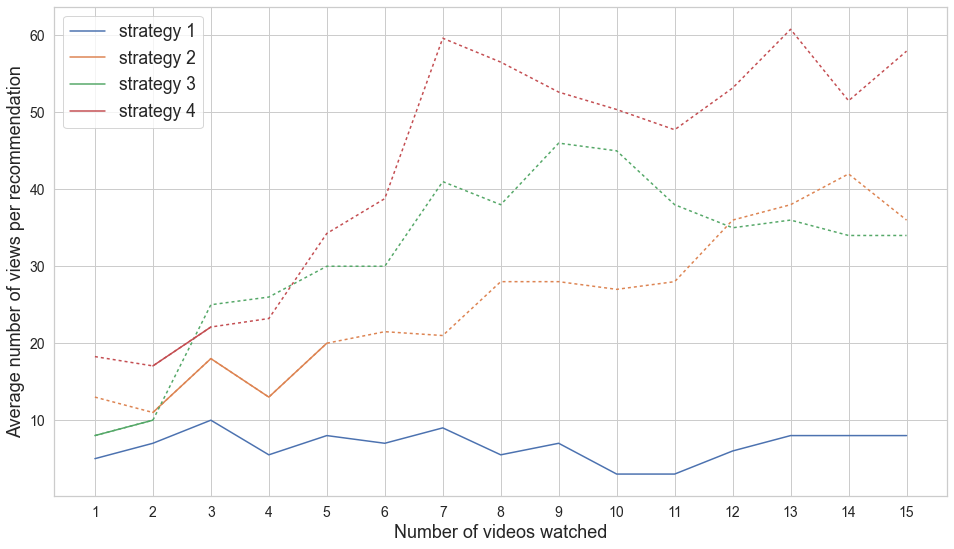

In [17]:
# Pivot
pivot = pd.pivot_table(combined,
                       index = ("strategy", "user"),
                       columns = "vids_watched",
                       values = "conspiracy_pred",
                       aggfunc = np.mean)

# Fill na with average of previous and next cell in column
pivot = (pivot.fillna(method="ffill", axis = 1) + pivot.fillna(method="bfill", axis = 1)) / 2 

grouped = pivot.groupby("strategy").mean()

# Plot
plt.figure(figsize=(16,9))

# Values and labels
x = grouped.columns
y = grouped.values * 100
labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

# Get colors per label
colors = dict(zip(labels, sns.color_palette('deep', 4)))

for y_val, label in zip(y, labels):
    # Plot significance for strategies other than 1
    if label != "strategy 1":
        sig = np.array(sigs[label])
        
        # Do not draw insignificant y-values as regular lines
        # setting y to np.nan tells matplotlib not to draw anything
        # if this is not done, the insignificant lines will 'fill in' the gaps
        y_insig = np.repeat(np.nan, 15)
        y_insig[x[~sig] - 1] = y_val[~sig]

        plt.plot(x, y_insig, label=label, color=colors[label]);
        plt.plot(x, y_val, '-.', dashes=(2, 2), color=colors[label]);
        
    else:
        plt.plot(x, y_val, label=label)

plt.xticks(np.arange(1, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Average number of views per recommendation", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})
plt.savefig('views.pdf')

### Split strategy into individual users

<AxesSubplot:xlabel='vids_watched'>

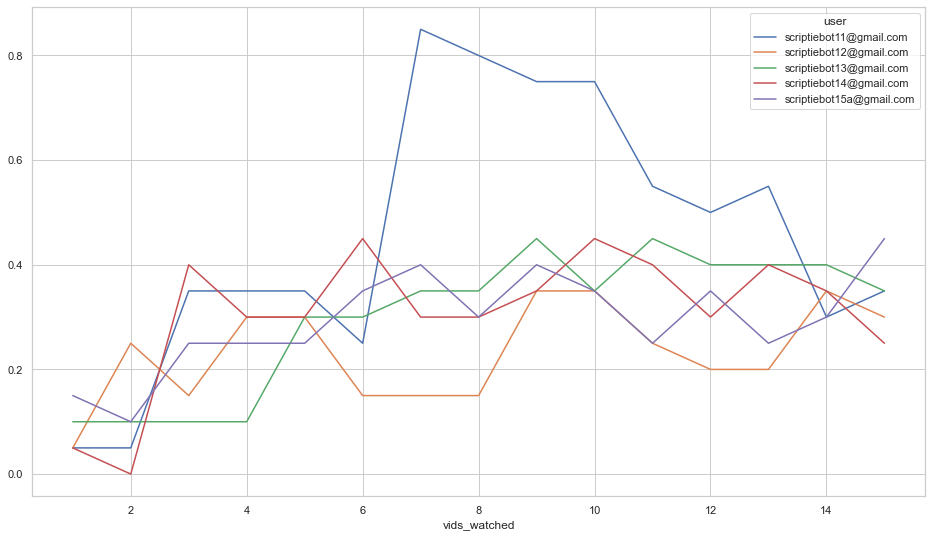

In [18]:
pivot.loc["strategy 3"].T.plot(figsize=(16,9))

# Similarity measures

In [19]:
combined_con = combined[combined["conspiracy_pred"] == True]
combined_reg = combined[combined["conspiracy_pred"] == False]

In [20]:
def tfidf(combined):
    return combined.groupby(["user",
                             "strategy",
                             "vids_watched"])["full_text"].apply(lambda x: 
                                                                 cosine_similarity(v.transform(x)))

In [21]:
similarities = tfidf(combined)
similarities_con = tfidf(combined_con)
similarities_reg = tfidf(combined_reg)

In [22]:
# only take the left triangle of the matrix (so no duplicates)
def fixer(array):     
    triangle = []
    
    # Take left triangle
    for i in range(len(array)):
        triangle.extend(array[i, :i])
        
    triangle = np.array(triangle)
        
    # If not enough videos are present, set the similarity to 0       
    if len(triangle) < 2:
        triangle = np.array([0])
    
    return triangle

similarities = similarities.apply(lambda x: fixer(x))
similarities_con = similarities_con.apply(lambda x: fixer(x))
similarities_reg = similarities_reg.apply(lambda x: fixer(x))

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

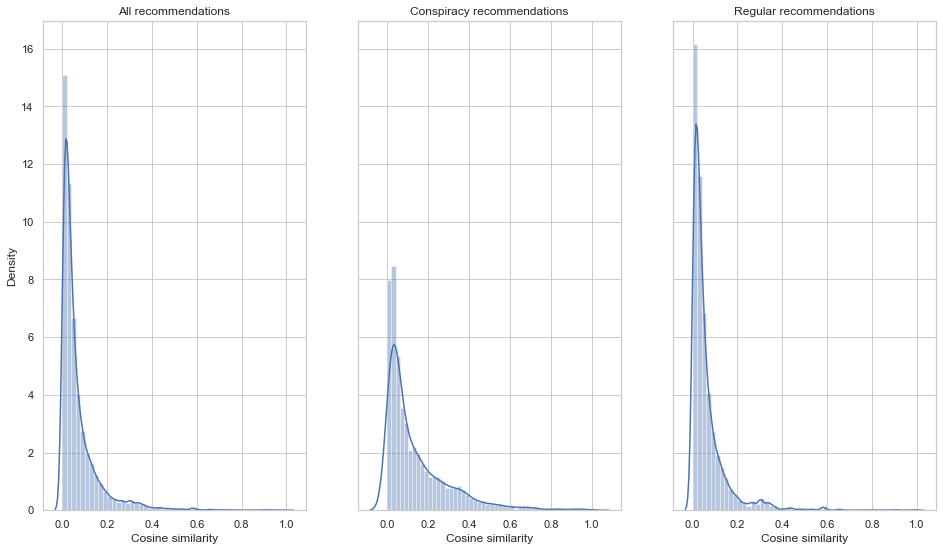

In [23]:
# Show distribution
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 9), sharey=True)

for idx, sim in enumerate([similarities, similarities_con, similarities_reg]):
    titles = ["All recommendations", "Conspiracy recommendations", "Regular recommendations"]
    sims = []
    for i in sim.iteritems():        
        sims.extend(list(i[1]))
                        
    sns.distplot(np.array(sims), ax=ax[idx])
    
    ax[idx].set(xlabel='Cosine similarity', title=titles[idx])

In [24]:
def group_2(sim_df, strategy, i):
    return sim_df.loc[(sim_df.index.get_level_values("strategy") == strategy)][i].groupby("user").mean().values

In [25]:
def sim_sig(sim_df):
    results_sim = defaultdict(dict)
    sigs_sim = defaultdict(list)

    for strategy in ["strategy 2", "strategy 3", "strategy 4"]:
        for i in range(1, 16):
            # Calculate p-value for each strategy at each number of videos
            x = group_2(sim_df, "strategy 1", i)
            y = group_2(sim_df, strategy, i)

            x_mean = np.nanmean(x)
            y_mean = np.nanmean(y)

            x_idx = np.where(np.isnan(x))
            y_idx = np.where(np.isnan(y))

            x[x_idx] = x_mean
            y[y_idx] = y_mean

            results_sim[strategy][i] = ttest_ind(x, y, alternative="smaller")[1]

    for strat in results_sim:
        for vid in results_sim[strat]:
            # Store whether or not the results were significant
            if results_sim[strat][vid] < 0.05:
                sigs_sim[strat].append(True)
            else:
                sigs_sim[strat].append(False)
                
    return sigs_sim

In [26]:
sim_df = similarities.apply(np.mean).unstack()
sim_df_con = similarities_con.apply(np.mean).unstack()
sim_df_reg = similarities_reg.apply(np.mean).unstack()

sigs = sim_sig(sim_df)
sigs_con = sim_sig(sim_df_con)
sigs_reg = sim_sig(sim_df_reg)

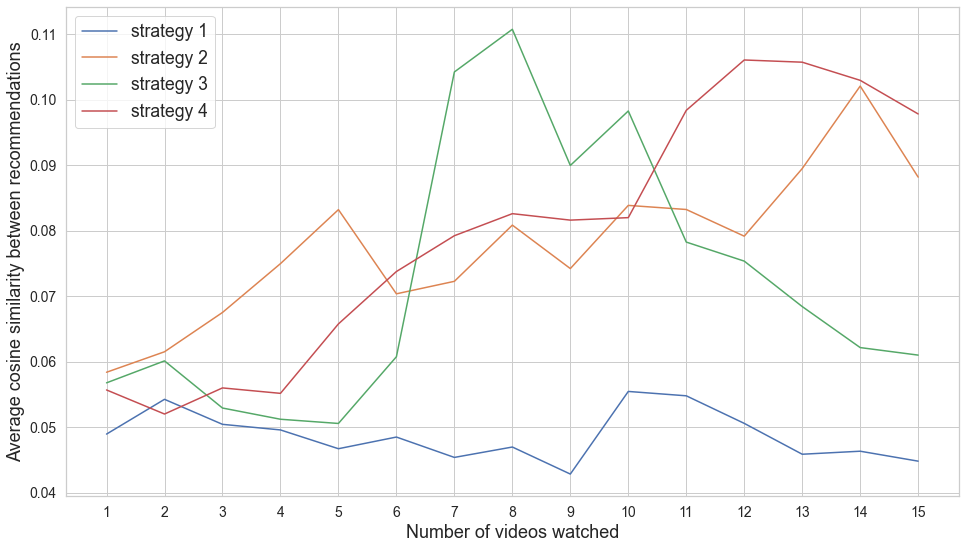

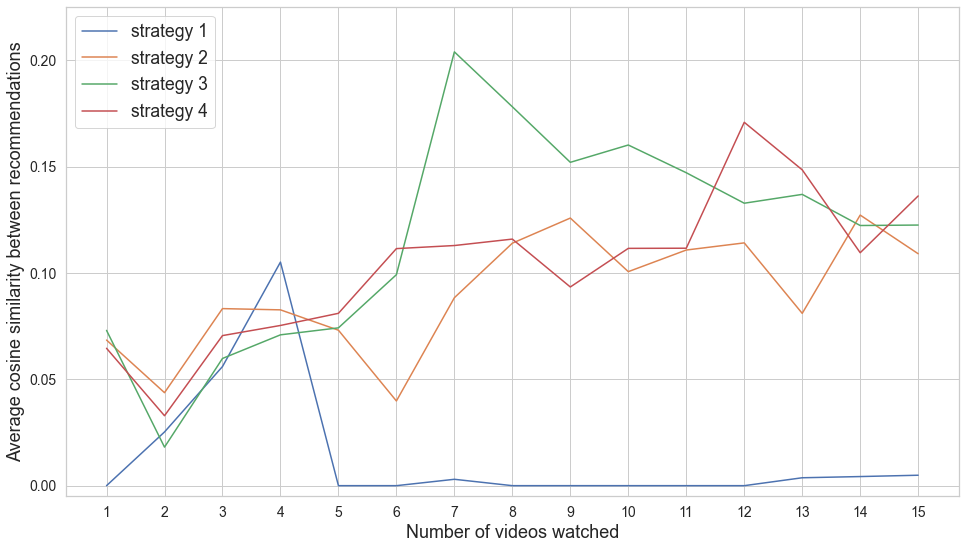

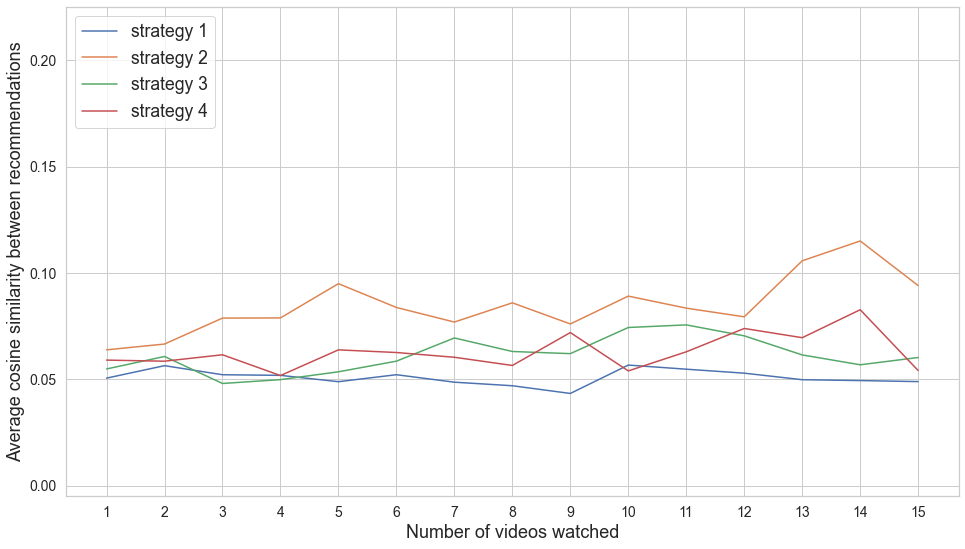

In [29]:
for name, sim, sigs_sim in [("All recommendations", similarities, sigs), 
                            ("Conspiracy recommendations", similarities_con, sigs_con),
                            ("Regular recommendations", similarities_reg, sigs_reg)]:
    
    pivot_2 = sim.apply(np.mean).groupby(["strategy", "vids_watched"]).mean().unstack().T

    # Plot
    plt.figure(figsize=(16,9))

    # Values and labels
    x = pivot_2.index
    y = pivot_2.values.T
    labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

    # Get colors per label
    colors = dict(zip(labels, sns.color_palette('deep', 4)))

    for y_val, label in zip(y, labels):
        plt.plot(x, y_val, label=label)

    plt.ylabel("Average cosine similarity between recommendations", fontsize=18);
    plt.xlabel("Number of videos watched", fontsize=18);

    plt.xticks(np.arange(1, 16, 1), fontsize=14);
    plt.yticks(fontsize=14);

    if name != "All recommendations":
        plt.ylim(-0.005, 0.225)
        
    plt.legend(loc="upper left", prop = {"size": 17.5});

    plt.savefig(f'{name}.pdf')

# Experiment 2 results

## Retrieve data

In [29]:
recs_2_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_exp_2_clean.csv").drop("Unnamed: 0", axis = 1)
recs_3_2 = pd.read_csv("../data/recommendations/recommendations_strat_3_exp_2_clean.csv").drop("Unnamed: 0", axis = 1)
recs_4_2 = pd.read_csv("../data/recommendations/recommendations_strat_4_exp_2_clean.csv").drop("Unnamed: 0", axis = 1)

In [30]:
recs_tfidf_2_2 = v.transform(recs_2_2["full_text"].values)
recs_tfidf_3_2 = v.transform(recs_3_2["full_text"].values)
recs_tfidf_4_2 = v.transform(recs_4_2["full_text"].values)

In [31]:
try:
    combined_2 = pd.read_csv("predicted_2.csv")
except:    
    recs_1["conspiracy_pred"] = svm.predict(recs_tfidf_1)
    recs_2_2["conspiracy_pred"] = svm.predict(recs_tfidf_2_2)
    recs_3_2["conspiracy_pred"] = svm.predict(recs_tfidf_3_2)
    recs_4_2["conspiracy_pred"] = svm.predict(recs_tfidf_4_2)
    
    recs_1["strategy"] = "strategy 1"
    recs_2_2["strategy"] = "strategy 2"
    recs_3_2["strategy"] = "strategy 3"
    recs_4_2["strategy"] = "strategy 4"
    
    combined_2 = pd.concat([recs_1, recs_2_2, recs_3_2, recs_4_2], ignore_index=True)
    
    combined_2.to_csv("predicted_2.csv")

In [32]:
combined_2["duration"] = combined_2["duration"].apply(lambda x: to_seconds(str(x)))

In [33]:
combined_2.head()

,Unnamed: 0,user,vids_watched,vid,views,likes,dislikes,duration,full_text,conspiracy_pred,strategy,channel
0,0,scriptiebot1@gmail.com,1,Jjge2pYKuUM,6708535.0,124784.0,5625.0,303,If 2 egg 1 glass oat make recip 5 minut If 2 e...,False,strategy 1,NaN
1,1,scriptiebot1@gmail.com,1,5yx6BWlEVcY,22824307.0,236476.0,4479.0,0,chillhop radio jazzi lofi hip hop beat welcom ...,False,strategy 1,NaN
2,2,scriptiebot1@gmail.com,1,Bj9PLkKNF-c,83168.0,1456.0,12.0,2900,ajax doc legaci johan cruijff johan cruijff le...,False,strategy 1,NaN
3,3,scriptiebot1@gmail.com,1,SMNHZR1u6KQ,8784881.0,103138.0,3495.0,0,live broadcast the holi quran channel makkah l...,False,strategy 1,NaN
4,4,scriptiebot1@gmail.com,1,46siYNcHMxM,408031.0,10729.0,380.0,3481,7 basic principl kemet ancient egyptian spirit...,False,strategy 1,NaN


In [34]:
results_2 = defaultdict(dict)
sigs_2 = defaultdict(list)

for strategy in ["strategy 2", "strategy 3", "strategy 4"]:
    for i in range(1, 16):
        # Calculate p-value for each strategy at each number of videos
        x = group(combined_2, "strategy 1", i, "conspiracy_pred")
        y = group(combined_2, strategy, i, "conspiracy_pred")
        results_2[strategy][i] = ttest_ind(x, y, alternative="smaller")[1]
    
for strat in results_2:
    for vid in results_2[strat]:
        # Store whether or not the results were significant
        if results_2[strat][vid] < 0.05:
            sigs_2[strat].append(True)
        else:
            sigs_2[strat].append(False)
            
for i in sigs_2:
    a = [sigs[i][-1]]
    a.extend(sigs_2[i])
    sigs_2[i] = a
    
sigs_2

defaultdict(list,
            {'strategy 2': [True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              False,
              False,
              True],
             'strategy 3': [True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True],
             'strategy 4': [True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              Tr

## Plot

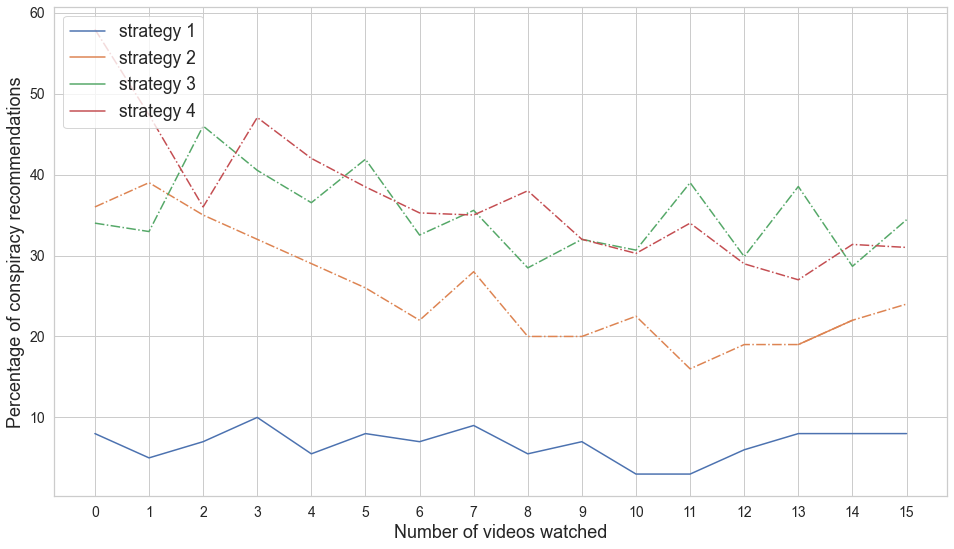

In [35]:
# Pivot
pivot_2 = pd.pivot_table(combined_2,
                         index = ("strategy", "user"),
                         columns = "vids_watched",
                         values = "conspiracy_pred",
                         aggfunc = np.mean)

# Fill na with average of previous and next cell in column
pivot_2 = (pivot_2.fillna(method="ffill", axis = 1) + pivot_2.fillna(method="bfill", axis = 1)) / 2 

grouped_2 = pivot_2.groupby("strategy").mean()

grouped_2[0] = grouped[15]
grouped_2 = grouped_2[range(16)]

# Plot
plt.figure(figsize=(16,9))

x = grouped_2.columns
y = grouped_2.values * 100
labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

for y_val, label in zip(y, labels):
    # Plot significance
    if label != "strategy 1":
        sig = np.array(sigs_2[label])
        
        # Do not draw insignificant y-values as regular lines
        # setting y to np.nan tells matplotlib not to draw anything
        # if this is not done, the insignificant lines will 'fill in' the gaps
        y_insig = np.repeat(np.nan, 16)
        y_insig[x[~sig]] = y_val[~sig]
        
        plt.plot(x, y_insig, label=label, color=colors[label]);
        plt.plot(x, y_val, '-.', color=colors[label]);
    else:
        plt.plot(x, y_val, label=label)

plt.xticks(np.arange(0, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})

plt.savefig('conspiracy_recs_2.pdf')
plt.show()